In [ ]:
pip install google-cloud-bigquery db-dtypes

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/retail-analysis-468900-7fc4757bbb7e.json"

In [ ]:
from google.cloud import bigquery
import os

# Upload file JSON ke Colab dulu
service_account_path = "/content/retail-analysis-468900-9216d37c5ad6.json"  # ganti sesuai nama file JSON

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = service_account_path

# Inisialisasi client
client = bigquery.Client(project="retail-analysis-468900")

# Query contoh
query = """
SELECT *
FROM `retail-analysis-468900.Fashion_Boutique_2025.Final_Retail_Analysis_Data_Quarter`
LIMIT 10
"""
df = client.query(query).to_dataframe()
df.head()

,product_id,category,brand,season,size,color,original_price,markdown_percentage,current_price,purchase_date,stock_quantity,customer_rating,is_returned,return_reason,purchase_quarter
0,FB000892,Accessories,Forever21,Spring,None,Brown,64.56,43.0,36.80,2024-08-06,36,4.5903,False,None,Q3
1,FB002004,Dresses,Uniqlo,Spring,L,Purple,146.68,0.0,146.68,2024-08-07,8,0.0000,False,None,Q3
2,FB000496,Tops,Ann Taylor,Spring,None,Beige,51.69,33.4,34.43,2024-08-07,36,4.5750,False,None,Q3
3,FB000480,Shoes,Mango,Spring,XS,Pink,124.26,0.0,124.26,2024-08-08,44,4.0000,False,None,Q3
4,FB001048,Tops,Uniqlo,Spring,XS,Red,25.45,0.0,25.45,2024-08-10,29,4.5841,False,None,Q3


In [ ]:
# 1. IMPORT LIBRARIES
# ========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Encode categorical features
for col in ['category', 'brand', 'season', 'color']:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Features & target
X = df[['original_price', 'markdown_percentage', 'current_price',
        'customer_rating', 'category', 'brand', 'season', 'color']]
y = df['is_returned'].astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiyatmij0/9yvdrc9n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiyatmij0/kpni82hv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70317', 'data', 'file=/tmp/tmpiyatmij0/9yvdrc9n.json', 'init=/tmp/tmpiyatmij0/kpni82hv.json', 'output', 'file=/tmp/tmpiyatmij0/prophet_model0mv534_q/prophet_model-20250828105605.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:56:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:56:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


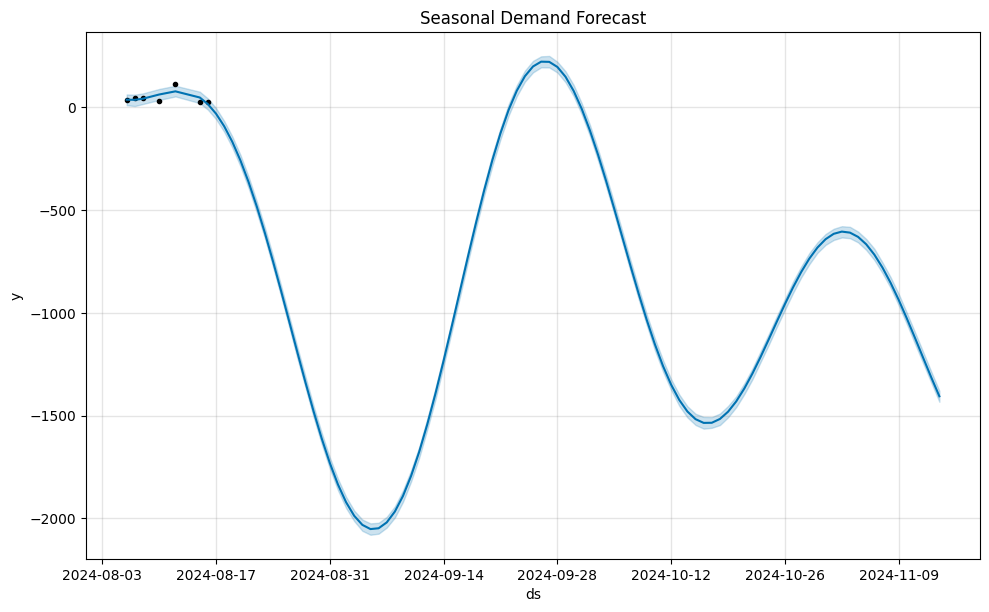

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Aggregate purchase quantity per date
ts = df.groupby('purchase_date')['stock_quantity'].sum().reset_index()
ts.columns = ['ds', 'y']

# Build model
model = Prophet(yearly_seasonality=True, daily_seasonality=False)
model.fit(ts)

# Forecast 90 hari ke depan
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# Plot
model.plot(forecast)
plt.title("Seasonal Demand Forecast")
plt.show()

In [ ]:
import statsmodels.api as sm

# Hitung return rate per level harga
pricing_df = df.groupby('markdown_percentage')['is_returned'].mean().reset_index()

X = sm.add_constant(pricing_df['markdown_percentage'])
y = pricing_df['is_returned']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            is_returned   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.208
Method:                 Least Squares   F-statistic:                    0.1383
Date:                Thu, 28 Aug 2025   Prob (F-statistic):              0.729
Time:                        10:56:41   Log-Likelihood:                -2.3670
No. Observations:                   6   AIC:                             8.734
Df Residuals:                       4   BIC:                             8.317
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0628    

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


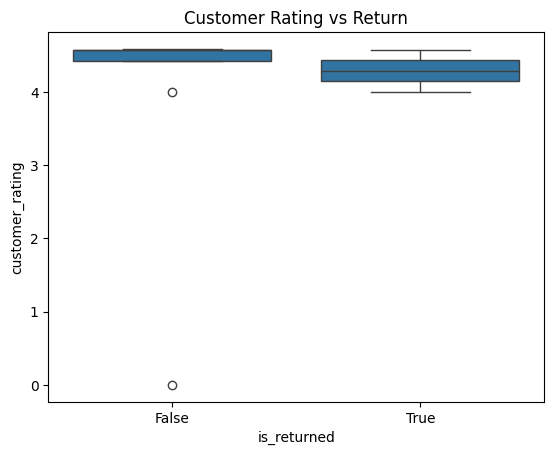

                 customer_rating  is_returned
customer_rating         1.000000     0.105147
is_returned             0.105147     1.000000


In [ ]:
import seaborn as sns

sns.boxplot(x='is_returned', y='customer_rating', data=df)
plt.title("Customer Rating vs Return")
plt.show()

# Korelasi rating & return
print(df[['customer_rating', 'is_returned']].corr())

In [ ]:
inventory = df.groupby('product_id')['stock_quantity'].sum().reset_index()
inventory = inventory.sort_values(by='stock_quantity', ascending=False)

# Hitung cumulative share
inventory['cum_share'] = inventory['stock_quantity'].cumsum() / inventory['stock_quantity'].sum()

# Klasifikasi ABC
inventory['ABC'] = pd.cut(
    inventory['cum_share'],
    bins=[0, 0.7, 0.9, 1.0],
    labels=['A', 'B', 'C']
)

print(inventory.head(20))

  product_id  stock_quantity  cum_share ABC
7   FB001583              49   0.154088   A
1   FB000480              44   0.292453   A
8   FB001622              43   0.427673   A
2   FB000496              36   0.540881   A
3   FB000892              36   0.654088   A
4   FB001048              29   0.745283   B
0   FB000236              25   0.823899   B
6   FB001409              25   0.902516   C
5   FB001268              23   0.974843   C
9   FB002004               8        1.0   C
